In [2]:
%matplotlib inline
import matplotlib
import urllib
from bs4 import BeautifulSoup
import shapefile
import pandas as pd
import re
from shapely import geometry
import os
import seaborn
from collections import defaultdict
from shapely import ops
import pickle
import matplotlib.pyplot  as plt
from shapely import speedups
import numpy as np
import pandas as pd
#from yelp.client import Client
#from yelp.oauth1_authenticator import Oauth1Authenticator
#from haversine import haversine
import numpy as np
import math
import shapely
import shapefile
import os
import scipy as sp
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import glob
import shapefile
#import mpl_toolkits.basemap.pyproj as pyproj
from sklearn import cluster
from IPython import display
from collections import defaultdict
import pickle
import json
import utm
from collections import defaultdict
from numpy import linalg
import shapefile
from itertools import combinations
from descartes import PolygonPatch
%matplotlib inline


## First we read in the data

In [24]:
sf = shapefile.Reader("ZIP_CODE_040114/ZIP_CODE_040114.shp")
sf_ref = sf.shapeRecords()

In [3]:
sf2 = shapefile.Reader("new-york_new-york.imposm-shapefiles/new-york_new-york_osm_admin.shp")
sf_ref2 = sf2.shapeRecords()

In [11]:
sf = shapefile.Reader("new-york_new-york.imposm-shapefiles/new-york_new-york_osm_admin.shp")
sf_ref = sf.shapeRecords()
names = {"Kings County":"Brooklyn","Queens County":"Queens","Richmond County":"Statten Island",
         "New York County":"Manhattan","Bronx County":"Bronx"}
ny_records = {}
polygons = []
for rec in sf_ref:
    name = rec.record[2]
    if rec.record[-1] == 6 and name in names:
        poly = geometry.Polygon(rec.shape.points)
        if not poly.is_valid:
            poly = poly.buffer(0)[1]
        ny_records[names[name]] = poly


minLat = np.inf
maxLat = -np.inf
minLng = np.inf
maxLng = -np.inf
for bur in ny_records:
    lng,lat = ny_records[bur].boundary.xy
    lngMin,lngMax = min(lng),max(lng)
    latMin,latMax = min(lat), max(lat)
    if lngMin < minLng:
        minLng = lngMin
    if lngMax > maxLng:
        maxLng = lngMax
    if latMin < minLat:
        minLat = latMin
    if latMax > maxLat:
        maxLat = latMax



def get_grid(spacing):
    latNums = int((maxLat-minLat)/spacing)
    lngNums =int((maxLng-minLng)/spacing)
    latAr = np.linspace(minLat-10**(-10),maxLat+10**(-10), latNums)
    lngAr= np.linspace(minLng-10**(-10), maxLng+10**(-10),lngNums)
    boxes = []
    for i in range(len(lngAr)-1):
        for j in range(len(latAr)-1):
            boxes.append(geometry.box(lngAr[i],latAr[j],lngAr[i+1],latAr[j+1]))
    return (np.array(boxes).reshape(len(lngAr)-1, len(latAr)-1),latAr,lngAr)


def get_relevant(boxes):
    relevant = []
    full_NYC = ops.unary_union([ny_records[val] for val in ny_records])
    for box in boxes.flatten():
        if box.intersects(full_NYC):
            keep = True
            relevant.append(box.intersection(full_NYC))
        else:
            relevant.append(None)
    return np.array(relevant).reshape(boxes.shape)



SPACING = 0.005/4



BOXES,latAr,lngAr = get_grid(SPACING)



RELEVANT = get_relevant(BOXES)



Self-intersection at or near point -74.039740173399863 40.699024314884056


In [130]:
nyc_centroid = {"lat":40.6639206199602,"lng": -73.9383529238219}
bounds_of_nyc = {"lat":(minLat,maxLat), "lng":(minLng, maxLng)}

In [12]:
get_index(maxLat,maxLng, latAr,lngAr)

(445, 350)

In [6]:
def get_index(lat,lng,latAr,lngAr):
    jLat = np.argmax(lat <= latAr)-1
    iLng = np.argmax(lng<=lngAr)-1
    return (iLng,jLat)
def get_burough(coord,records):
    #lat_str = "_latitude"
    #lng_str = "_longitude"
    #NYC = get_NYC_records(sf)
    #shapes = sf.shapes()
    point = geometry.Point(coord[::-1])

    for bur, poly in records.items():
        #if poly[0].contains(point):
        if poly.contains(point):
            return bur
    return None
def get_all_burough(df, drop_or_pick = "pickup"):
    coords = df[[drop_or_pick + "_lat",drop_or_pick +"_long"]].values
    return map(lambda x: get_burough(x,ny_records),coords)




def get_all_boxes(df,latAr,lngAr):
    coord_pick = df[["pickup_lat", "pickup_long"]].values
    coord_drop = df[["dropoff_lat", "dropoff_long"]].values
    pick_vals = pd.DataFrame({"pick_grid":map(lambda x: get_index(*x,latAr = latAr,lngAr = lngAr), coord_pick)})
    drop_vals = pd.DataFrame({"drop_grid":map(lambda x: get_index(*x,latAr = latAr,lngAr = lngAr), coord_drop)})
    return pd.concat([pick_vals,drop_vals], axis = 1)


# In[9]:

def get_rest_boxes(df,latAr,lngAr):
    coords = df[["Lat","Long"]].values
    return pd.DataFrame({"grid_point":map(lambda x: get_index(*x,latAr = latAr,lngAr = lngAr), coords)})

In [ ]:
COLUMNS = [u'VendorID', u'tpep_pickup_datetime', u'tpep_dropoff_datetime',
       u'passenger_count', u'trip_distance', u'pickup_longitude',
       u'pickup_latitude', u'RateCodeID', u'store_and_fwd_flag',
       u'dropoff_longitude', u'dropoff_latitude', u'payment_type',
       u'fare_amount', u'extra', u'mta_tax', u'tip_amount', u'tolls_amount',
       u'improvement_surcharge', u'total_amount', u'Pickup_Borough',
       u'Pickup_Neighbourhood', u'Pickup_Zip_code', u'Dropoff_Borough',
       u'Dropoff_Neighbourhood', u'Dropoff_Zip_code']

TO_USE = [u'tpep_pickup_datetime', u'tpep_dropoff_datetime',u'passenger_count', u'trip_distance', u'pickup_longitude',
       u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude', u'payment_type',
       u'fare_amount', u'tip_amount', u'total_amount', u'Pickup_Borough',
       u'Pickup_Neighbourhood', u'Pickup_Zip_code', u'Dropoff_Borough',
       u'Dropoff_Neighbourhood', u'Dropoff_Zip_code']


INDEX_TO_USE = [COLUMNS.index(item) for item in TO_USE]
dfTotal = pd.read_csv("taxi_data/yellow_01_new.csv")
dfTotal.columns =  ["pickup_datetime", "dropoff_datetime","passenger_count", "trip_distance",\
                                        "pickup_long","pickup_lat","dropoff_long","dropoff_lat", \
                                        "payment_type","fare_amount","tip_amount","total_amount",u'Pickup_Borough',\
                                u'Pickup_Neighbourhood', u'Pickup_Zip_code', u'Dropoff_Borough',\
                                u'Dropoff_Neighbourhood', u'Dropoff_Zip_code']

In [7]:
dfTotal.loc[:,["Pickup_Zip_code","Dropoff_Zip_code"]] = dfTotal[["Pickup_Zip_code","Dropoff_Zip_code"]].apply\
(lambda x: pd.to_numeric(x,errors='coerce'))

The datetime information in the original dataframe is a string which we split and turn into two datetime obejcts, the date and the time of the pickup.

In [8]:
def convert_datetime(df):
    cols = ["pickup_datetime","dropoff_datetime"]
    for col in cols:
        df.loc[:,col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [9]:
convert_datetime(dfTotal)

In [10]:
dfTotal.shape

(12748986, 18)

In [11]:
dfTotal.dropna(axis = 0, subset = ["Pickup_Zip_code","Dropoff_Zip_code"],inplace = True)

In [12]:
dfTotal.shape

(12465439, 18)

To make filtering easier we add a year, month and day of week columns to the dataframe. It will also be useful to have a duration column, and to add a time of day category which is determined by the hour of the day.

In [13]:
def round_to_nearest(time_stamp):
    minutes = time_stamp.minute
    seconds = time_stamp.second
    if minutes%5 < 2:
        val = (minutes/5)*5
    elif minutes%5 >= 3:
        val =  (minutes/5 +1)*5
    else:
        if seconds <= 30:
            val=  (minutes/5)*5
        else:
            val =  (minutes/5+1)*5
    return val

In [14]:
def add_details(df):
    df.loc[:,"pickup_month"] = df["pickup_datetime"].apply(lambda x: x.month)
    df.loc[:,"pickup_day"] = df["pickup_datetime"].apply(lambda x: x.weekday())
    df.loc[:,"duration"] = df["dropoff_datetime"]-df["pickup_datetime"]
    df.loc[:,"time_category_pick"] = df["pickup_datetime"].apply(lambda x: x.hour)
    df.loc[:,"time_category_drop"] = df["dropoff_datetime"].apply(lambda x: x.hour)
    df.loc[:,"minute_drop"] = df["dropoff_datetime"].apply(lambda x: round_to_nearest(x))


In [15]:
dfTotal.loc[:,"dropoff_day"] = dfTotal["dropoff_datetime"].apply(lambda x: x.weekday())

In [16]:
add_details(dfTotal)

In [17]:
def half_hour_grading(date_time):
    time = date_time.time()
    h,m = time.hour,time.minute
    if m < 30:
        m = 0
    else:
        m = 0.5
    return h + m

To ensure that all latitudes and longitudes are within the bounds of NYC we should specifiy appropriate limits, to be specific we will use those specified on https://www.maptechnica.com/us-city-boundary-map/city/New%20York/state/NY/cityid/3651000. Note that if we wish to project onto flat coordinates we can use EPSG 2831 (EPSG 2263 if using ft). Also, we should exclude any trips that have a negative duration.

In [18]:
def clean_data(df, bounds, remove_airport = True):
    min_lat, max_lat = bounds["lat"]
    min_long, max_long = bounds["lng"]
    dfFilter = df[(min_lat <= df.pickup_lat) &(df.pickup_lat <= max_lat) & (min_long <= df.pickup_long) \
                  &(df.pickup_long<= max_long)]
    dfFilter = dfFilter[(min_lat <= dfFilter.dropoff_lat) &(dfFilter.dropoff_lat <= max_lat) \
                       & (min_long <= dfFilter.dropoff_long)  &(dfFilter.dropoff_long<= max_long)]
    dfFilter = dfFilter[dfFilter.duration >= datetime.timedelta(0)]
    #if remove_airport:
    #    dfFilter = dfFilter[dfFilter.rate_code.isin([1,5,6])]
    return dfFilter

In [19]:
dfTotal = clean_data(dfTotal,bounds_of_nyc,True)

We have the following map for the days of the week

In [20]:
gridVals = get_all_boxes(dfTotal,latAr,lngAr)

In [21]:
#burVals = pd.Series(get_all_burough(dfTotal))
#burVals = pd.DataFrame({"bur":burVals})
gridVals = gridVals.reset_index(drop = True)
dfTotal = dfTotal.reset_index(drop = True)
#burVals = burVals.reset_index(drop=True)
dfTotal = pd.concat([dfTotal,gridVals], axis = 1)

In [22]:
dfTotal.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_long,pickup_lat,dropoff_long,dropoff_lat,payment_type,fare_amount,...,Dropoff_Zip_code,dropoff_day,pickup_month,pickup_day,duration,time_category_pick,time_category_drop,minute_drop,pick_grid,drop_grid
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,-73.974785,40.750618,1,12.0,...,10017.0,3,1,3,00:18:03,19,19,25,"(211, 217)","(226, 217)"
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,-73.994415,40.759109,1,14.5,...,10036.0,5,1,5,00:19:50,20,20,55,"(205, 196)","(211, 224)"
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,-73.951820,40.824413,2,9.5,...,10031.0,5,1,5,00:10:03,20,20,45,"(235, 259)","(245, 276)"
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,-74.004326,40.719986,2,3.5,...,10013.0,5,1,5,00:01:52,20,20,35,"(199, 188)","(203, 193)"
4,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,-74.004181,40.742653,2,15.0,...,10011.0,5,1,5,00:19:19,20,20,55,"(229, 227)","(203, 211)"


# Clubs

In [14]:
import dill
from collections import Counter, defaultdict

In [25]:
with open("agg_data_1.dill","r") as f:
    agg = dill.load(f)

In [26]:
night = agg.night

In [27]:
night.loc[:,"percent"] = night.groupby("burs")["counts"].apply(lambda x: 100.0*x/x.sum())

In [28]:
night.loc[:,"percent"] = night.groupby("burs")["percent"].apply(lambda x: x/x.max())

In [29]:
night.dropna(subset = ["percent"], inplace = True)

In [30]:
night = night.sort_values(["burs","percent"])

In [31]:
night = night[night["counts"]> 0]

In [32]:
night.head()

,Name,Lat,Long,counts,burs,grid,percent
78,el aguila,40.867927,-73.900519,19.0,Bronx,"(286, 311)",0.218391
130,raine lounge,40.880146,-73.903085,30.0,Bronx,"(284, 321)",0.344828
141,silhouette,40.880673,-73.902481,30.0,Bronx,"(284, 321)",0.344828
53,bamboo lounge,40.828647,-73.917079,31.0,Bronx,"(272, 280)",0.356322
138,salsa con fuego,40.862369,-73.911422,87.0,Bronx,"(277, 306)",1.000000


In [33]:
to_drop = ["simplicity bar and lounge","9a west harlem",'hudson river cafe lounge','un chin','uptown social ', 
           'copia nyc', 'fish bar nyc pier 81','rv rooftop', 'pacha nyc', 'rdv', 'latin quarters', 'toy','glazz']

In [34]:
night = night[~night["Name"].isin(to_drop)]

In [35]:
to_fix = ['el tina lounge','the cutting room nyc', 'st. cloud rooftop nyc',
       'pranna restaurant,bar and lounge', 'slate lounge nyc','lust ny', 'vista sky rooftop',
       'la gloria bar and lounge', 'cavo queens']
to_fix_new = ['el tina','the cutting room', 'st. cloud rooftop',
       'pranna', 'slate lounge','lust', 'vista sky lounge',
       'la gloria', 'cavo']

In [36]:
night.replace(to_fix,to_fix_new,inplace=True)

In [37]:
yelpApi = {'consumer_key':'3jffArKDsaePUgv38n-BTg','consumer_secret':'OQz8L2Xw5k2T0nJ5w8m0jRnTwAY',
'token':'dkArqbT1VYXU3ULesh5rkKPAk_WcaqG6','token_secret':'g8jpFo5xKpRMUDot0Nmq19aVeHY'}

In [38]:
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

In [39]:
auth = Oauth1Authenticator(**yelpApi)
client = Client(auth)

In [40]:
extra = []
for name in night.Name:
    params = {"term":name,'limit':1}
    try:
        search = client.search("New York",**params).businesses[0]
        Name = search.name
        url = search.url
        
    except IndexError:
        Name = name
        url = None
    extra.append([Name,url])

In [41]:
night_extra = pd.concat([night.reset_index(drop =True),pd.DataFrame(extra,columns=["Name_Yelp","url"])],axis = 1)

In [56]:
night_test = night_extra[night_extra["counts"]>100]

In [57]:
night_test.shape

(147, 9)

In [58]:
max(night_test["grid"].values)

(310, 216)

In [78]:
night_test.shape

(147, 9)

In [62]:
night_test.to_csv("/Users/tjrempel/dataIncubator/Analysis/Taxi_Analysis/heroku_new/night_info.csv",encoding = 'utf-8')

In [44]:
info = []
for f in os.listdir(os.getcwd()):
    if "club_info" in f:
        name = f[10:12]
        info.append((name, dill.load(open(f))))

In [45]:
Total = Counter()
for item in info:
    Total += item[1]

In [70]:
zips = set()
collect = defaultdict(dict)
for item in Total:
    grid = item[0]
    
    if item[1]>9999:
        zips.add(item[1])
        collect[grid][item[1]] = Total[item]

In [71]:
collect_per = {}
for key in collect:
    dict_zip = collect[key]
    total = 1.0*sum(dict_zip.values())
    max_val = max(dict_zip.values())/total
    new_dict = {}
    if total > 100:
        for key2 in dict_zip:
            new_dict[key2] = (dict_zip[key2]/total)/max_val
        collect_per[key] = new_dict

In [66]:
max(collect_per.keys())

(310, 216)

In [79]:
collect_per[(310,216)]

{10001.0: 0.18333333333333335,
 10002.0: 0.058333333333333334,
 10003.0: 0.54999999999999993,
 10004.0: 0.016666666666666666,
 10006.0: 0.041666666666666664,
 10007.0: 0.016666666666666666,
 10009.0: 0.016666666666666666,
 10010.0: 0.074999999999999997,
 10011.0: 0.15833333333333333,
 10012.0: 0.083333333333333329,
 10013.0: 0.099999999999999992,
 10014.0: 0.18333333333333335,
 10016.0: 0.69999999999999996,
 10017.0: 0.27499999999999997,
 10018.0: 0.64166666666666672,
 10019.0: 0.33333333333333331,
 10020.0: 0.0083333333333333332,
 10021.0: 0.24166666666666664,
 10022.0: 0.27499999999999997,
 10023.0: 0.22500000000000001,
 10024.0: 0.14999999999999999,
 10025.0: 0.099999999999999992,
 10026.0: 0.049999999999999996,
 10028.0: 0.19999999999999998,
 10029.0: 0.049999999999999996,
 10031.0: 0.024999999999999998,
 10033.0: 0.0083333333333333332,
 10036.0: 0.29999999999999999,
 10038.0: 0.049999999999999996,
 10040.0: 0.049999999999999996,
 10065.0: 0.20833333333333334,
 10075.0: 0.041666666

In [374]:
sorted?

In [375]:
max(collect_per.keys(), key = lambda x: x[1])

(270, 310)

In [67]:
with open("/Users/tjrempel/dataIncubator/Analysis/Taxi_Analysis/heroku_new/zip_club.dill","w") as f:
    dill.dump(collect_per, f)

In [68]:
sf = shapefile.Reader("cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k.shp")

In [69]:
sf_ref = sf.shapeRecords()

In [72]:
zip_rec = []
for rec in sf_ref:
    zip_rec.append(rec.record[2])

In [73]:
from matplotlib.gridspec import GridSpec

In [74]:
rel_records = defaultdict(list)
test = []
for rec in sf_ref:
    if rec.record[2] in zips:
        poly = geometry.Polygon(rec.shape.points)
        if not poly.is_valid:
            poly = poly.buffer(0)
        rel_records[int(rec.record[2])].append(poly)
        test.append(rec)

Self-intersection at or near point -73.97720099999998 40.758537999999994
Self-intersection at or near point -73.98326299999998 40.761093999999993
Self-intersection at or near point -74.093788442911105 40.612679099347211
Self-intersection at or near point -74.230342678974523 40.508495080512731
Self-intersection at or near point -73.962526223455285 40.7680234502768
Self-intersection at or near point -74.097174646492945 40.614378351572512
Self-intersection at or near point -74.012730999999974 40.717113999999981
Self-intersection at or near point -73.87091015830444 40.859017743631668
Self-intersection at or near point -73.880529784326242 40.652193549841421
Self-intersection at or near point -73.782570920214866 40.712846069035407
Self-intersection at or near point -73.900331999999977 40.768807999999993
Self-intersection at or near point -73.978680662189021 40.753621459212802
Self-intersection at or near point -73.942711968712899 40.79908377186274
Self-intersection at or near point -73.97679

In [75]:
for key, item in rel_records.items():
    if item[0].geom_type == 'MultiPolygon':
        rel_records[key] = [poly for poly in item[0]]

In [76]:
records_xy = {}
for key, gons in rel_records.items():
    if len(gons) > 1:
        temp = [poly.exterior.xy for poly in gons]
        records_xy[key] = temp
    else:
        records_xy[key] = [gons[0].exterior.xy]
        
    

In [77]:
with open("/Users/tjrempel/dataIncubator/Analysis/Taxi_Analysis/heroku_new/zip_polys.dill", "w") as f:
    dill.dump(records_xy,f)

In [79]:
t = rel_records[10001][0]

In [80]:
t.is_valid

Self-intersection at or near point -73.999460557731922 40.751441848892362


False

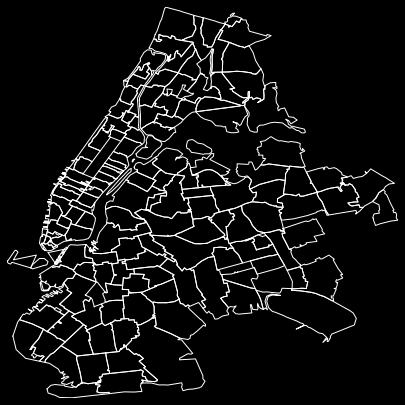

In [94]:
fig = plt.figure(figsize=(7,7), dpi=1000)
gs = GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])
sns.despine(fig)
sns.set_style("dark")
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})

ax1 = fig.gca()
ax1.set_yticks([])
ax1.set_xticks([])

#fig.suptitle(time, fontsize=30)
#ax2 = fig.add_subplot(212)
for item in rel_records:
#     x1, y1 = poly[0].exterior.xy
#     ax1.plot(x1, y1)
    polygon = rel_records[item][0]
    try:
        x2,y2 = polygon.exterior.xy
#         x2, y2 = poly.exterior.xy
        ax1.plot(x2, y2,"white",lw = 1)
    except AttributeError:
        for poly in polygon:
            x2,y2 = poly.exterior.xy
            ax1.plot(x2,y2,"white",lw = 1)


# for index,box in np.ndenumerate(relevant1):
#     if box:
#         try:
#             #x,y = box.exterior.xy
            
#             ax1.add_patch(PolygonPatch(box,  ec ="white"))
#         except AssertionError:
            
#             for poly in box:
                
#                 ax1.add_patch(PolygonPatch(poly,ec = "white"))

# Banks

In [24]:
import dill
import pandas as pd

In [25]:
with open("banks.dill","r") as f:
    dfB = dill.load(f)

In [5]:
dfB.to_csv("banks.csv",index = False, encoding='utf-8')

In [26]:
dfTotal =  dfTotal[(dfTotal["dropoff_day"] != 6) | (dfTotal["dropoff_day"] != 0)]
dfTotal = dfTotal[((5 <= dfTotal["time_category_drop"]) & (dfTotal["time_category_drop"]<= 9))]

In [27]:
dfB.loc[:,"grid"]=dfB[["Lat","Long"]].apply(lambda x : get_index(*x,latAr= latAr,lngAr = lngAr), axis = 1)

In [28]:
dfTotal.shape

(1849571, 26)

In [29]:
uniqe_grids = dfB["grid"].unique()

In [32]:
uniqe_grids

array([(228, 223), (195, 189), (218, 225), (227, 224), (224, 226),
       (226, 221), (229, 223), (227, 221), (228, 228), (218, 209),
       (221, 222), (223, 227), (225, 225), (224, 224), (222, 226),
       (229, 224), (198, 185), (197, 193), (222, 224), (199, 182),
       (223, 220), (227, 225), (221, 225), (227, 226), (230, 222),
       (208, 188), (194, 189), (223, 228), (216, 222), (220, 226),
       (215, 199), (195, 182), (224, 217), (231, 227), (222, 219),
       (198, 184), (227, 227), (228, 225), (229, 229), (218, 221)], dtype=object)

In [33]:
drops = dfTotal.groupby("drop_grid")

In [31]:
dfCountB = pd.concat([drops.get_group(g) for g in uniqe_grids])

In [32]:
dfCountB.columns

Index([      u'pickup_datetime',      u'dropoff_datetime',
               u'trip_distance',           u'pickup_long',
                  u'pickup_lat',          u'dropoff_long',
                 u'dropoff_lat',          u'payment_type',
                 u'fare_amount',            u'tip_amount',
                u'total_amount',        u'Pickup_Borough',
        u'Pickup_Neighbourhood',       u'Pickup_Zip_code',
             u'Dropoff_Borough', u'Dropoff_Neighbourhood',
            u'Dropoff_Zip_code',           u'dropoff_day',
                u'pickup_month',            u'pickup_day',
                    u'duration',    u'time_category_pick',
          u'time_category_drop',           u'minute_drop',
                   u'pick_grid',             u'drop_grid'],
      dtype='object')

In [33]:
dfCountB.head()

,pickup_datetime,dropoff_datetime,trip_distance,pickup_long,pickup_lat,dropoff_long,dropoff_lat,payment_type,fare_amount,tip_amount,...,Dropoff_Zip_code,dropoff_day,pickup_month,pickup_day,duration,time_category_pick,time_category_drop,minute_drop,pick_grid,drop_grid
3947,2015-01-06 07:34:46,2015-01-06 07:41:25,1.24,-73.963242,40.771915,-73.972679,40.758297,1,7.0,1.00,...,10022.0,1,1,1,00:06:39,7,7,40,"(236, 234)","(228, 223)"
7853,2015-01-22 06:37:48,2015-01-22 06:43:11,1.17,-73.971649,40.746239,-73.973351,40.757835,2,6.0,0.00,...,10017.0,3,1,3,00:05:23,6,6,45,"(229, 214)","(228, 223)"
9171,2015-01-30 08:20:09,2015-01-30 08:28:49,1.00,-73.962669,40.758247,-73.973000,40.757427,1,7.5,1.50,...,10022.0,4,1,4,00:08:40,8,8,30,"(236, 223)","(228, 223)"
13977,2015-01-08 07:43:54,2015-01-08 07:48:41,1.25,-73.972862,40.744289,-73.973106,40.757858,1,6.0,1.20,...,10017.0,3,1,3,00:04:47,7,7,50,"(228, 212)","(228, 223)"
17172,2015-01-19 07:58:35,2015-01-19 08:10:17,3.10,-74.006401,40.733162,-73.972733,40.757469,1,11.5,2.45,...,10022.0,0,1,0,00:11:42,7,8,10,"(201, 203)","(228, 223)"


In [52]:
zips = dfCountB.groupby("Pickup_Zip_code").agg('size')[2:]

In [54]:
zipdf = pd.DataFrame({"zip_code":zips.index, "count":zips.values},dtype = float)

In [55]:
zipdf["percent"] = 100*zipdf["count"]/zipdf["count"].sum()

In [56]:
zipdf= zipdf[zipdf["percent"]> 0.01]

In [57]:
zipdf.to_csv("invest_banks.csv",index = False,float_format="%.0f")

In [58]:
zips = pd.read_csv("invest_banks.csv")

In [60]:
zips.sort_values("zip_code")

,count,zip_code,percent
0,8298,10001,7
1,575,10002,1
2,4345,10003,4
3,588,10004,1
4,722,10005,1
5,173,10006,0
6,681,10007,1
7,1135,10009,1
8,3767,10010,3
9,4861,10011,4


In [30]:
dfCountB.shape

(111033, 26)

In [28]:
import dill

In [266]:
with open("cluster_02.dill","r") as f:
    test = dill.load(f)

In [273]:
for i in range(1,13):
    if i < 10:
        name = "0" + str(i)
    else:
        name = str(i)
    name = "cluster_"+name+".dill"
    with open(name, "r") as f:
        temp = dill.load(f)
    new_cluster = transform_cluster(temp)
    
    new_name = "new_" + name
    with open(new_name,"w") as f:
        dill.dump(new_cluster,f)

In [151]:
from shapely import geometry

In [269]:
res = transform_cluster(test)

In [272]:
res[(2,1,0)]["poly"].iloc[0]

(array('d', [-73.9533996582, -73.9555511475, -73.9545135498, -73.9541168213, -73.9533996582]),
 array('d', [40.7283554077, 40.730102539099995, 40.7302589417, 40.7302894592, 40.7283554077]))

In [268]:
def transform_cluster(test):
    allowed = ["Manhattan","Brooklyn","Bronx","Queens","Staten Island"]
    new_cluster = {}
    for key in test:
        bur = key[1]
        if bur in allowed:
            df = test[key]
            df.loc[:,"nP"] = df["percent"]/(df["percent"].max() + 0.00001)
            new_key = tuple(list(key[2:]))
            if new_key in new_cluster:
                new_cluster[new_key] = pd.concat([new_cluster[new_key],df]).reset_index(drop = True)
            else:
                new_cluster[new_key] = df
        
    for key in new_cluster:
        df = new_cluster[key]
        valid = np.where([type(val) == geometry.polygon.Polygon for val in df["poly"]])
        df = df.iloc[valid].reset_index(drop = True)
        df.loc[:,"poly"] = df["poly"].apply(lambda x: x.exterior.xy)
        new_cluster[key] = df
    return new_cluster

In [199]:
new_cluster = {}
for key in test:
    bur = key[1]
    if bur in allowed:
        df = test[key]
        df.loc[:,"nP"] = df["percent"]/(df["percent"].max() + 0.00001)
        new_key = tuple(list(key[2:]))
        if new_key in new_cluster:
            new_cluster[new_key] = pd.concat([new_cluster[new_key],df]).reset_index(drop = True)
        else:
            new_cluster[new_key] = df
    else:
        cc += test[key].shape[0] 

In [197]:
type(new_cluster[(1, 5, 23)]["poly"].iloc[0])

shapely.geometry.polygon.Polygon

In [187]:
from descartes import PolygonPatch

In [188]:
not_working = []

In [240]:
import matplotlib

In [241]:
matplotlib.colors.rgb2hex(cmap(0))

u'#222222'

In [244]:
with open("cmap.dill", "w") as f:
    dill.dump(cmap,f)

In [33]:
dfCountB[["pickup_lat","pickup_long"]].values

array([[ 40.77191544, -73.96324158],
       [ 40.74623871, -73.97164917],
       [ 40.75824738, -73.96266937],
       ..., 
       [ 40.76979065, -73.95162964],
       [ 40.7400589 , -73.98948669],
       [ 40.74550629, -73.97219086]])

In [163]:
tt = testing.get_group((219,227))

In [164]:
tt.columns

Index([u'pickup_long', u'pickup_lat', u'Pickup_Zip_code', u'drop_grid'], dtype='object')

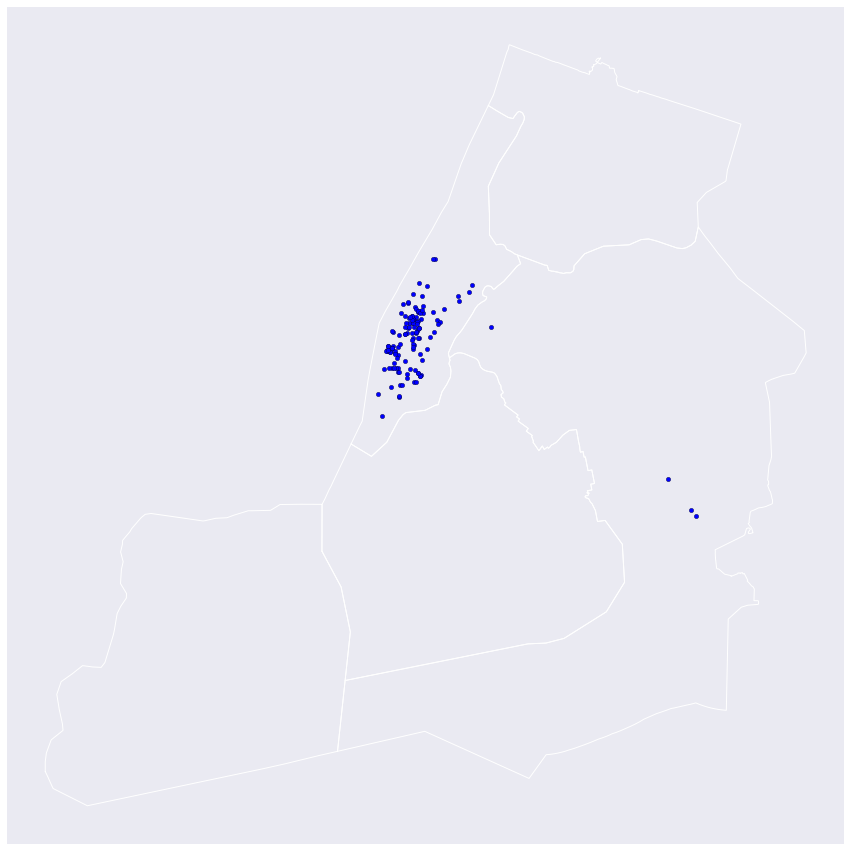

In [165]:
# temp = res[(1,5,21)] 
cmap = sns.light_palette('#FF0000', as_cmap=True)
fig = plt.figure(figsize=(15,15), dpi=1000)
ax1 = fig.add_subplot(111)
sns.despine(fig)
sns.set_style("dark")
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey'})

ax1 = fig.gca()
ax1.set_yticks([])
ax1.set_xticks([])

#ax2 = fig.add_subplot(212)
for poly in ny_records.values():
#     x1, y1 = poly[0].exterior.xy
#     ax1.plot(x1, y1)
    try:
        x2, y2 = poly.exterior.xy
        ax1.plot(x2, y2,"white",lw = 1)
    except AttributeError:
        for poly in poly:
            x2,y2 = poly.exterior.xy
            ax1.plot(x2,y2,"white",lw = 1)
# ax = fig.gca()
# for row in temp.iterrows():
#     color = cmap(row[1]["normalized"])
#     ax1.add_patch(PolygonPatch(row[1][0], fill=True,fc = color, ec = color))
# x = gg["pickup_lat"].values
# y = gg["pickup_long"].values

# for i in range(len(x)):
#     ax1.scatter(y[i],x[i])

lat = tt["pickup_lat"].values
lng = tt["pickup_long"].values
plt.scatter(lng,lat)
# for index,box in np.ndenumerate(RELEVANT):
#     if box:
#         try:
#             #x,y = box.exterior.xy
            
#             ax1.add_patch(PolygonPatch(box,  ec ="white"))
#         except AssertionError:
            
#             for poly in box:
                
#                 ax1.add_patch(PolygonPatch(poly,ec = "white"))

plt.plot();

In [ ]:
test.keys()[0]

In [80]:
t1 = test[('01', 'Brooklyn', 1, 1, 8)]

In [77]:
t2 = test[('01', 'Manhattan', 1, 1, 8)]

In [81]:
pd.concat([t1,t2])

,poly,counts,percent,normalized
0,"POLYGON ((-73.9913635254 40.68542099, -73.9919...",61,0.848746,0.011696
1,"POLYGON ((-74.0006027222 40.675365448, -74.002...",667,6.636605,1.000000
2,"POLYGON ((-73.97923278810001 40.6827964783, -7...",29,0.854698,0.005599
3,"POLYGON ((-73.9584732056 40.7151947021, -73.95...",13,0.895775,0.002631
4,"POLYGON ((-73.9715042114 40.6760597229, -73.97...",12,0.759992,0.002060
5,"POLYGON ((-73.9882278442 40.6717414856, -73.98...",10,0.786210,0.001776
6,"POLYGON ((-73.9595031738 40.7089080811, -73.96...",14,0.715131,0.002262
7,"POLYGON ((-73.9840164185 40.6758460999, -73.98...",12,0.734485,0.001991
8,"POLYGON ((-73.97431182859999 40.6445770264, -7...",6,1.006244,0.001364
9,"POLYGON ((-73.9685974121 40.69222640989999, -7...",10,0.837563,0.001892


In [35]:
d = {1:10,2:11}

In [37]:
d[[1,2]]

TypeError: unhashable type: 'list'

In [38]:
set([[1,2],[3]])

TypeError: unhashable type: 'list'

In [42]:
# Enter your code here. Read input from STDIN. Print output to STDOUT
N = int(raw_input())
weights = map(int, raw_input().split())
weights_dict = dict((i+1,weights[i]) for i in range(N))
links = dict((i+1,[]) for i in range(N))
links_list = []

def flatten(l):
    return [item for sublist in l for item in sublist]

for i in range(N-1):
    
    l1,l2 = map(int, raw_input().split())
    links[l1].append(l2)
    links[l2].append(l1)
    
    links_list.append((l1,l2))

def calculate_weight(links_in_tree):
    total = 0
    for link in links_in_tree:
        total += weights_dict[link]
    return total

def get_nodes(root1,root2):
    if links[root1] == [root2]:
        nodes1 = [root1]
    elif links[root2] == [root1]:
        nodes1 = [root2]
    else:
        to_explore = [root1]
        nodes1 = set([root2])
        while to_explore:
            nodes1.add(*to_explore)
            current = list(set(flatten([links[val] for val in to_explore])) - nodes1)
            if current:
                nodes1.add(current)
                to_explore = current
            

        
                
        nodes1.remove(root2)
    nodes2 = list(set(range(1,N+1)) - set(nodes1))
    return (nodes1,nodes2) 
    
    

min_seen = None
for link_pair in links_list:
    l1,l2 = link_pair
    #print get_nodes(l1,l2)
    t1,t2 = get_nodes(l1,l2)
    diff = abs(calculate_weight(t1) -calculate_weight(t2))
    if min_seen is None:
        min_seen = diff
    else:
        if diff < min_seen:
            min_seen = diff
                  
    
print min_seen
    

TypeError: add() takes exactly one argument (2 given)

In [2]:
import pandas as pd

In [3]:
url = "https://storage.googleapis.com/taxi_ben/yellow_2015_"
for val in range(1,2):
    if val < 10:
        val = "0"+str(val)
    else:
        val = str(val)
    print val
    df = pd.read_csv(url+val+".csv")
    df.to_csv("taxi_data/yellow_"+val+".csv", index = False)
    del df

01


/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1]:
import pandas as pd
import dill

In [2]:
bank = pd.read_csv("bank_picks_01.csv")

In [ ]:
with open("agg_data.dill", "w") as f:
    test = 

In [3]:
bank

,count,zip_code
0,1.0,83.0
1,2.0,7310.0
2,6639.0,10001.0
3,456.0,10002.0
4,3556.0,10003.0
5,488.0,10004.0
6,598.0,10005.0
7,135.0,10006.0
8,561.0,10007.0
9,875.0,10009.0


In [ ]:
t = pd.read_csv("taxi_data/yellow_02.csv")

In [10]:
t.head()

,pickup_datetime,dropoff_datetime,trip_distance,pickup_long,pickup_lat,dropoff_long,dropoff_lat,payment_type,fare_amount,tip_amount,...,Pickup_Zip_code,Dropoff_Borough,Dropoff_Neighbourhood,Dropoff_Zip_code,pickup_month,pickup_day,duration,time_category_pick,dropoff_day,time_category_drop


# Where the Party Goers Came From

In [2]:
import os

In [62]:
night = pd.read_csv("Clubs.csv")
night.loc[:,"grid"]=night[["Lat","Long"]].apply(lambda x : get_index(*x,latAr= latAr,lngAr = lngAr), axis = 1)
night_grid = night["grid"].unique()
burs = map(lambda x: get_burough(x,ny_records), night[["Lat","Long"]].values)
night.loc[:,"burs"] = burs

In [63]:
night.head()

,Name,Lat,Long,grid,burs
0,howl at the moon,40.762905,-73.984268,"(219, 227)",Manhattan
1,pocket bar nyc,40.763365,-73.992299,"(212, 228)",Manhattan
2,the village underground,40.730694,-74.000923,"(206, 201)",Manhattan
3,birthday bottle service,40.747270,-73.980064,"(222, 215)",Manhattan
4,iron horse nyc,40.708137,-74.004943,"(202, 183)",Manhattan


In [23]:
import dill

In [187]:
info = []
for f in os.listdir(os.getcwd()):
    if "club_info" in f:
        name = f[10:12]
        info.append((name, dill.load(open(f))))
#         info.append(pd.read_csv(f))

In [32]:
from collections import Counter, defaultdict

In [70]:
testing = [val[1] for val in info]

In [89]:
night[night["Name"]=="output night club"]["grid"].values

array([(240, 195)], dtype=object)

In [92]:
tt = [collect[val] for val in night[night["Name"]=="output night club"]["grid"].values]

In [99]:
pd.DataFrame([tt[0]]).T.idxmax(axis = 0)

0    11211.0
dtype: float64

In [68]:
pd.DataFrame(collect)

ValueError: arrays must all be same length

In [61]:
night[night["Name"]=="the grain"]["zips"] = [1,2,3]

ValueError: Length of values does not match length of index

In [55]:
for item in collect:
    night[night["grid"]==item]["zips"] = collect[item]
    

ValueError: Length of values does not match length of index

In [322]:
aa = [1,2,3]
bb =["hi","bye","ab"]

In [323]:
zip(aa,bb)

[(1, 'hi'), (2, 'bye'), (3, 'ab')]

In [324]:
a,b= zip(*zip(aa,bb))

In [325]:
a

(1, 2, 3)

In [80]:
with open("agg_data_heat.dill", "r") as f:
    heat = dill.load(f)

In [84]:
sorted(heat.heat_map.keys())

[0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5]

In [85]:
4**3,3**4

(64, 81)

In [87]:
sum([4**3,3**4])

145

In [88]:
14/0.4

35.0